In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from model import AdderNet, AdderNet2_0
from Train import model_training
from quantization_encoder import Quant
from quantization_decoding import Quant_decode

In [ ]:
# Hyper parameters
test_batch_size = 128
in_channels = 3
out_channels = 16
kernel_size = 3

# Model device assignment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdderNet().to(device)

In [ ]:
# Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=0)

# Define the class names for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [07:33<00:00, 376kB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Editing .pth state dictionary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_state_dict = torch.load('AdderNet_model.pth', map_location=device)
fixed_state_dict = {}

def remap_key(key: str) -> str:
    """Map original checkpoint keys to the correct AdderNet naming."""
    new_key = key.replace('module.', '')

    # conv and batchnorm
    if new_key.startswith('conv1.') or new_key.startswith('bn1.') or new_key.startswith('fc.') or new_key.startswith('bn2.'):
        return new_key

    # Process residual layers
    for layer_num in [1, 2, 3]:
        prefix = f'layer{layer_num}.'
        if new_key.startswith(prefix):
            rest = new_key[len(prefix):]  # everything after 'layerX.'

            # If next is block index
            if rest[0].isdigit():
                block_num = rest[0]
                rest_after_block = rest[2:]

                # Handle downsample case
                if rest_after_block.startswith('downsample.'):
                    ds_rest = rest_after_block[len('downsample.'):]
                    if ds_rest.startswith('0.'):
                        return f'layer{layer_num}.downsample_adder.{ds_rest[2:]}'
                    elif ds_rest.startswith('1.'):
                        return f'layer{layer_num}.downsample_bn.{ds_rest[2:]}'

                # Otherwise: normal residual block conv/bn
                rest_after_block = rest_after_block.replace('conv1.', 'adder1.')
                rest_after_block = rest_after_block.replace('conv2.', 'adder2.')
                return f'layer{layer_num}.blocks.{block_num}.{rest_after_block}'

    # If nothing matches, just return
    return new_key

# Apply the mapping
for key, value in model_state_dict.items():
    fixed_key = remap_key(key)
    fixed_state_dict[fixed_key] = value

params = list(fixed_state_dict.items())
n_params = len(params)

Using device: cuda


In [ ]:
# AOQ of unsigned weight tensors for AdderNet2.0
quant_acc_2_0_U = []
bit_array = [16, 14, 12, 10, 8, 6, 5, 4, 3]
activations_dict2_0_U = {}
clipped_bias_dict_U = {}
clipped_weight_dict_U = {}

for i, bits in enumerate(bit_array):
  activations_dict2_0_U[bits] = {
    'input_activation_2.0': None,
    'prelayer_activation_2.0': None,
    'layer1_activation_2.0': None,
    'layer2_activation_2.0': None,
    'layer3_activation_2.0': None
  }

  quantized_state_dict = {k: v.clone() for k, v in fixed_state_dict.items()}

  max_val = max_activation_val
  Max_A = 2**(bits) - 1      # Maximum value: 127 for bits=8
  Max_B = 0                    # Minimum value: 0 for unsigned
  delta = max_val / (Max_A)

  print(f"\nProcessing {bits}-bit quantization. Delta Val: {delta}")

  x_tensor = quantized_state_dict['bn1.weight']
  xq_tensor = x_tensor / delta
  quantized_state_dict['bn1.weight'] = xq_tensor

  x_tensor = quantized_state_dict['bn1.bias']
  xq_tensor = x_tensor / delta
  quantized_state_dict['bn1.bias'] = xq_tensor

  clipped_bias_dict_U[bits] = {}
  clipped_weight_dict_U[bits] = {}

  for name in quantized_state_dict.keys():
      if name.startswith('layer'):
          if name.endswith('adder'):
              w_tensor = quantized_state_dict[name]
              wq = torch.round(w_tensor/delta)
              wq_clamp = torch.clamp(wq, max=Max_A, min=Max_B)
              quantized_state_dict[name] = wq_clamp
              bias_tensor = (wq - wq_clamp).abs()
              bias_sum = torch.sum(bias_tensor, dim=(1,2,3))
              clipped_weight_dict_U[bits][name] = wq_clamp.cpu().clone()
              clipped_bias_dict_U[bits][name.replace('adder', 'bn')] = bias_tensor.cpu().clone()
          if name.endswith('running_mean'):
              m_tensor = quantized_state_dict[name]
              mq = torch.round(m_tensor/delta)
              quantized_state_dict[name] = mq + bias_sum
          if name.endswith('bias'):
              x_tensor=quantized_state_dict[name]
              xq_tensor = x_tensor/delta
              quantized_state_dict[name] = xq_tensor

  quantized_state_dict['fc.weight']=quantized_state_dict['fc.weight']*delta

  quant_model = AdderNet2_0(num_classes=10).to(device)
  quant_model.load_manual_weights(quantized_state_dict)
  quant_model.eval()

  print(f"Testing {bits}-bit quantization AdderNet2.0")
  with torch.no_grad():
      number_correct = 0
      samples = 0
      first_batch = True
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = quant_model(images, save_activations=True)

          _, prediction = torch.max(outputs, 1)
          samples += labels.size(0)
          number_correct += (prediction == labels).sum().item()

          if first_batch:
            for name, activation in quant_model.activations.items():
              activations_dict2_0_U[bits][name] = activation.cpu().clone() # Fixed: Changed to activations_dict2_0_U
            first_batch = False

  accuracy = (number_correct / samples) * 100.0
  print(f"  Accuracy: {accuracy:.2f}%")

  del quant_model
  torch.cuda.empty_cache() if torch.cuda.is_available() else None
  quant_acc_2_0_U.append(accuracy)



Processing 16-bit quantization with FBR. Delta Val: 3.8147554741741054e-05
Testing 16-bit quantization AdderNet2.0
  Accuracy: 91.42%

Processing 14-bit quantization with FBR. Delta Val: 0.00015259720441921504
Testing 14-bit quantization AdderNet2.0
  Accuracy: 91.42%

Processing 12-bit quantization with FBR. Delta Val: 0.0006105006105006105
Testing 12-bit quantization AdderNet2.0
  Accuracy: 91.42%

Processing 10-bit quantization with FBR. Delta Val: 0.0024437927663734115
Testing 10-bit quantization AdderNet2.0
  Accuracy: 91.45%

Processing 8-bit quantization with FBR. Delta Val: 0.00980392156862745
Testing 8-bit quantization AdderNet2.0
  Accuracy: 91.57%

Processing 6-bit quantization with FBR. Delta Val: 0.03968253968253968
Testing 6-bit quantization AdderNet2.0
  Accuracy: 91.05%

Processing 5-bit quantization with FBR. Delta Val: 0.08064516129032258
Testing 5-bit quantization AdderNet2.0
  Accuracy: 90.82%

Processing 4-bit quantization with FBR. Delta Val: 0.16666666666666666


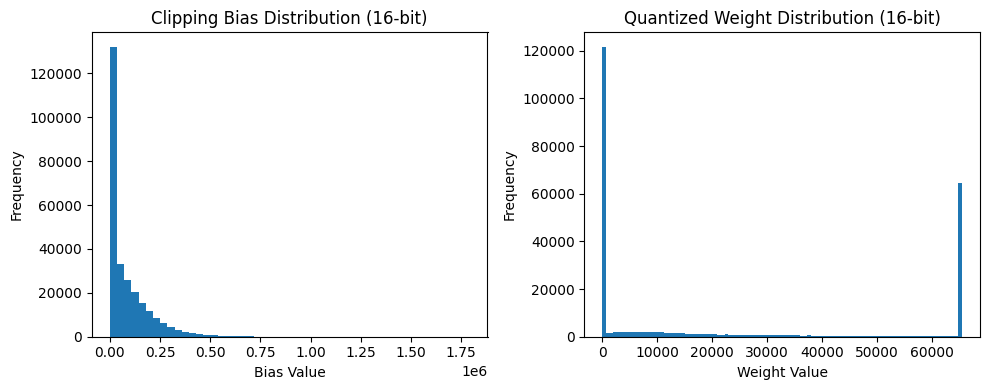

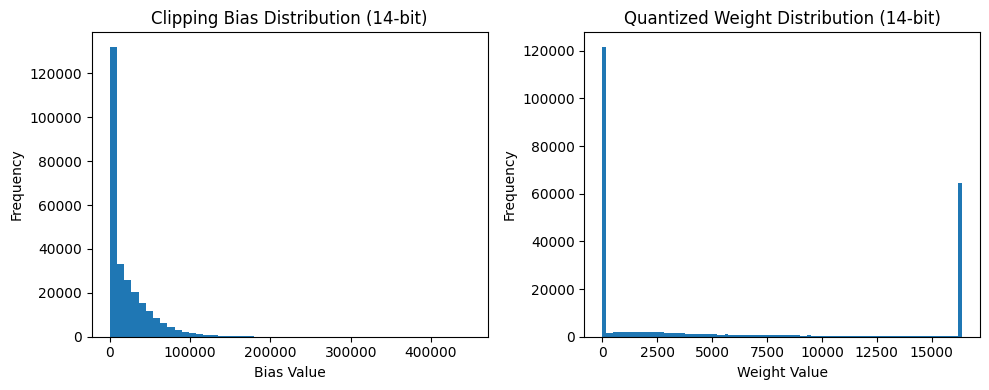

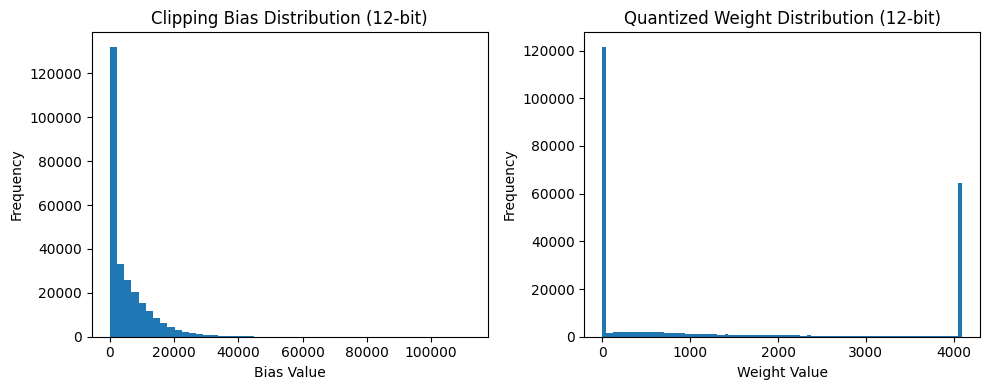

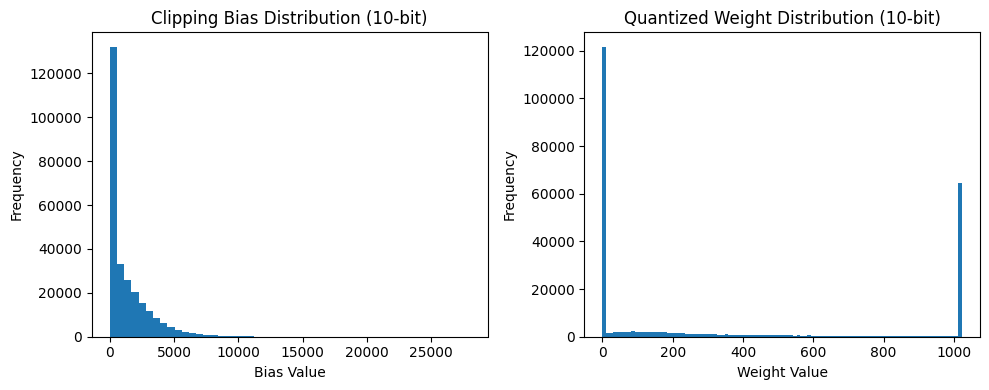

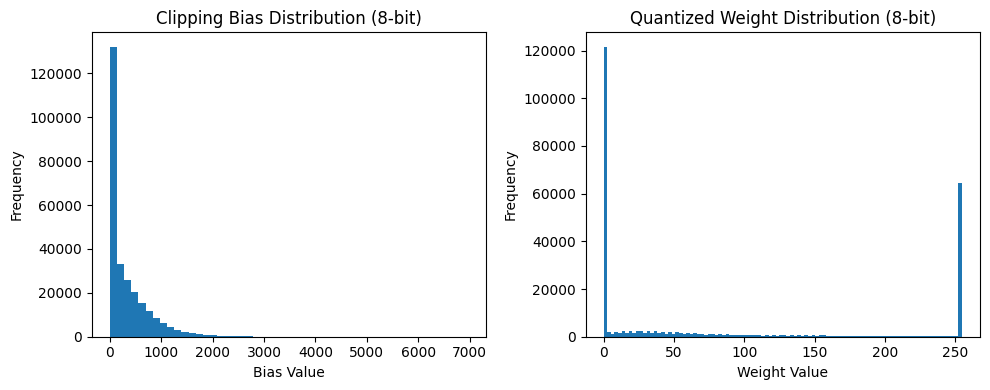

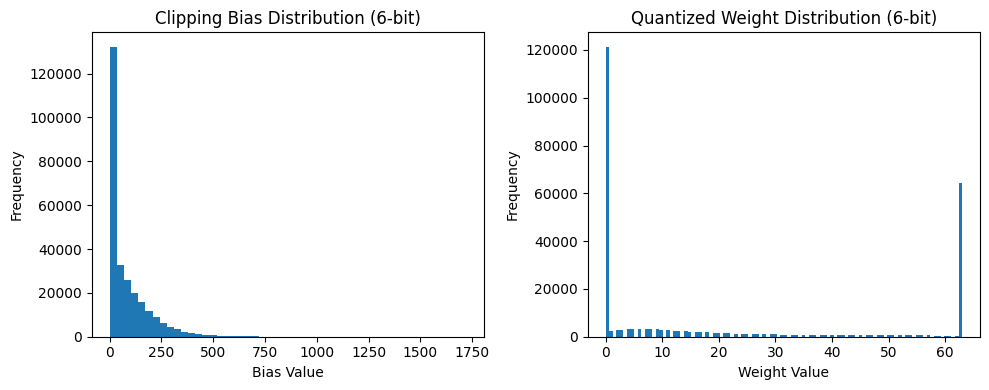

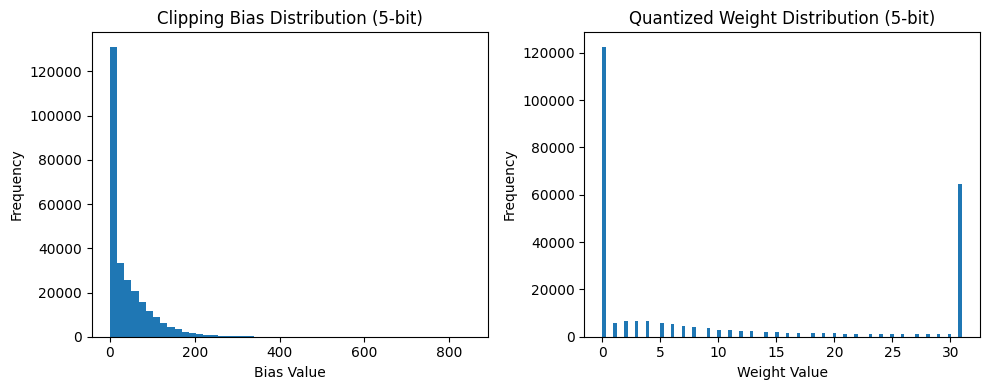

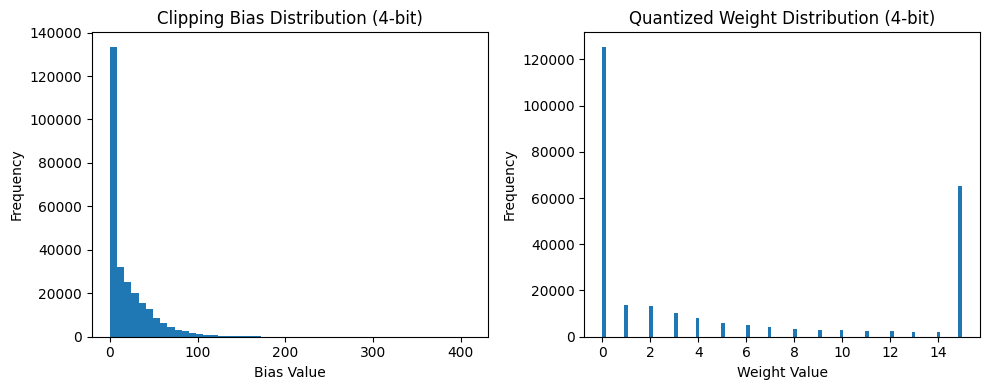

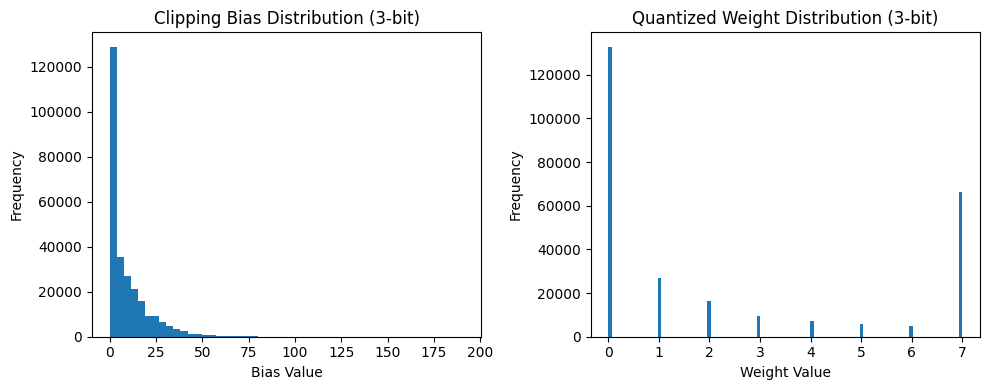

In [24]:
for bits in clipped_bias_dict_U.keys():
    # Plot bias distribution for this bit width
    all_biases = torch.cat([v.flatten() for v in clipped_bias_dict_U[bits].values()]).cpu().numpy()

    # Plot weight distribution for this bit width
    all_weights = torch.cat([v.flatten() for v in clipped_weight_dict_U[bits].values()]).cpu().numpy()

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(all_biases, bins=50)
    plt.title(f'Clipping Bias Distribution ({bits}-bit)')
    plt.xlabel('Bias Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(all_weights, bins=100)
    plt.title(f'Quantized Weight Distribution ({bits}-bit)')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

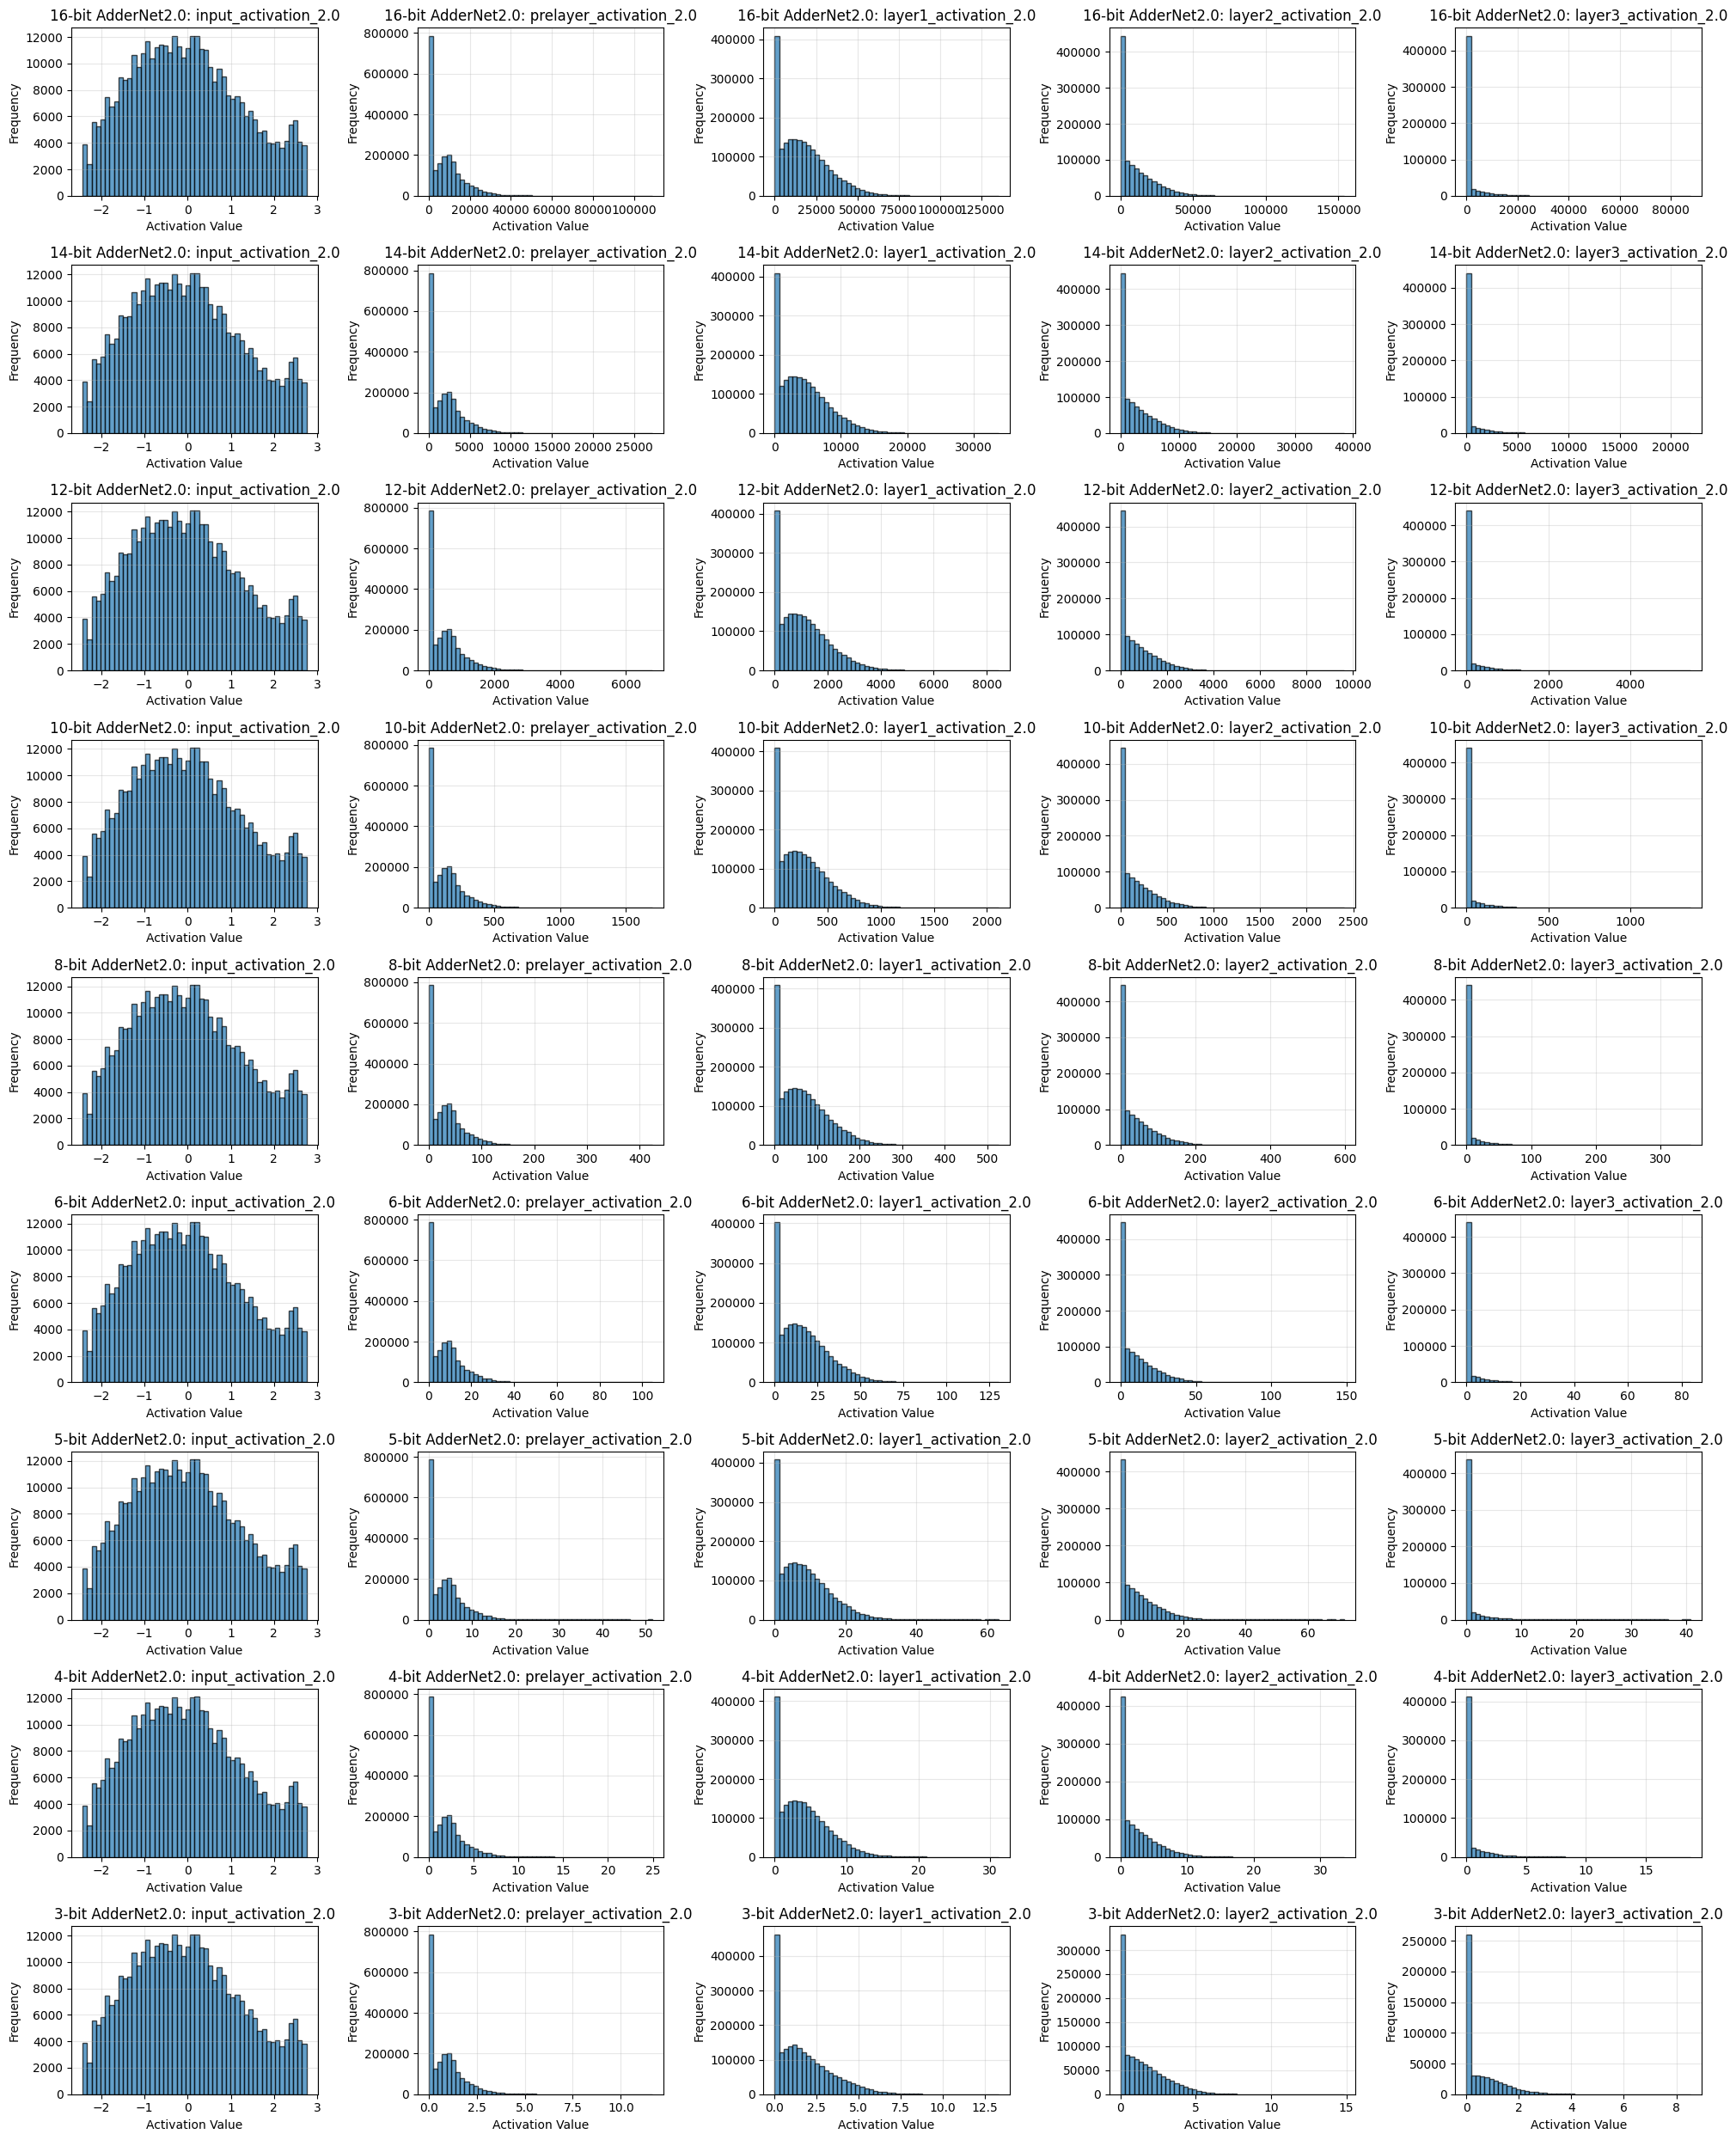

In [15]:
activation_names = list(activations_dict2_0_U[16].keys())
num_bits = len(bit_array)
num_activations = len(activation_names)

fig, axes = plt.subplots(num_bits, num_activations, figsize=(20, 25))

for i, bits in enumerate(bit_array):
  for j, name in enumerate(activation_names):
    ax = axes[i, j]

    act_values = activations_dict2_0_U[bits][name].cpu().flatten()

    ax.hist(act_values, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{bits}-bit AdderNet2.0: {name}')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

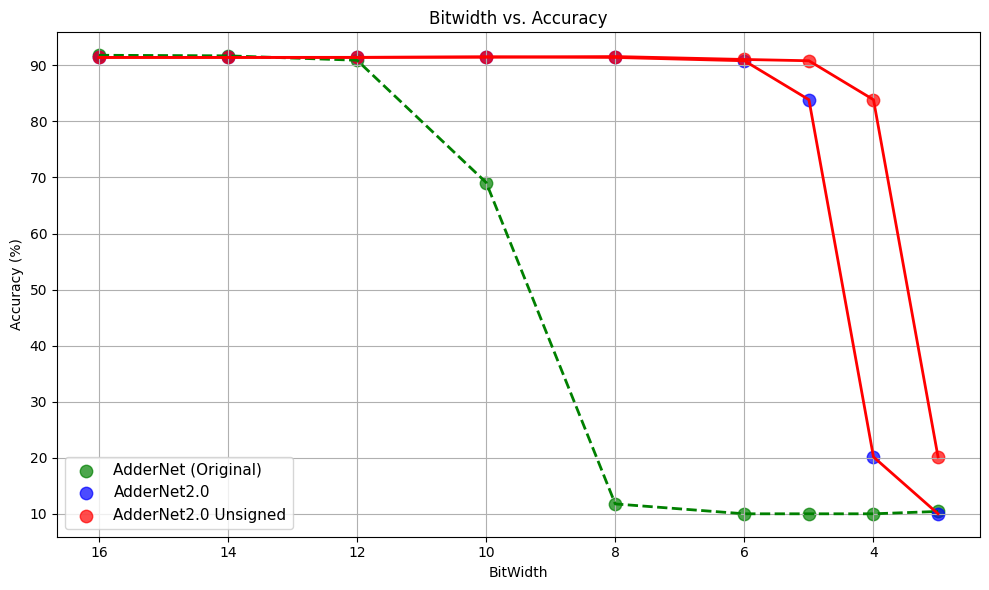

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bit_array, quant_acc_2_0_U, s=80, c='red', alpha=0.7, label='AdderNet2.0 Unsigned')
ax.plot(bit_array, quant_acc_2_0_U, linewidth=2, c='r')

ax.set_title('Bitwidth vs. Accuracy')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Accuracy (%)')
ax.legend(fontsize=11)
ax.grid(True)
ax.invert_xaxis()

plt.tight_layout()
plt.show()